# Exploratory Data Analysis & Data Quality Assessment

#### Importing datasets and necessary modules

In [1]:
import pandas as pd
import sklearn as sk
import plotly as pl
import matplotlib
import matplotlib.pyplot as plt
import math
import patsy as patsy
from scipy import stats
import pickle
import statsmodels.api as sm
import numpy as np 
import seaborn as sns
import missingno as msno
from dython import nominal
import folium
from folium import Map
from folium.plugins import HeatMap
from IPython.display import display_html
from itertools import chain,cycle


import functions as f

dftrain = pd.read_csv("/Users/andrewtobin/College/final_year/FYP/House_pricing_dataset-master/dataset_csv/train.csv",index_col='ad_id')
dftest  = pd.read_csv( "/Users/andrewtobin/College/final_year/FYP/House_pricing_dataset-master/dataset_csv/test.csv",index_col='ad_id')

In [2]:
pd.set_option('precision', 2)
# Setting the pandas output display options
pd.set_option('display.max_columns', 30)
pd.set_option('display.max_rows', 150)

In [3]:
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

In [ ]:
## Column Names
print("Training Data Info:")
dftrain.info() ## column names, count of non-null values, variable types

print("\n Descriptive Statistics for Numeric Data")
dftrain.describe() ## descriptive statistics for our numeric data

# Data Quality Assessment

## The Six Dimensions Data Quality Assessment

1) Timeliness    2) Completeness     3) Uniqueness      4) Validity     5) Consistency     6) Accuracy

### Timeliness: Ensuring that there is no latency between data being generated and data being used in the ML process (Ignored, not applicable)

As there is no database feeding our model and no real time data, we will be ignoring timeliness as a measure of data quality. If there were a database, it could be useful as the model would be trained to track market trends usings dates, in this scenario timeliness and data latency would be an important measure of data quality

### Completeness: The number of complete rows present in the data

Measure: % of complete rows, total and broken down by column

Number of Missing Values in Each Column

In [111]:
## checking for rows with NANs
print('Missing Values')
dftrain.isnull().sum(axis = 0)

Missing Values


area                     0
bathrooms               51
beds                    51
ber_classification     677
county                   0
description_block        0
environment              0
facility              2017
features                 0
latitude                 0
longitude                0
no_of_units           2923
price                   90
property_category        0
property_type           51
surface                551
dtype: int64

Text(0.5, 1.0, 'Null values by column visualised \n')

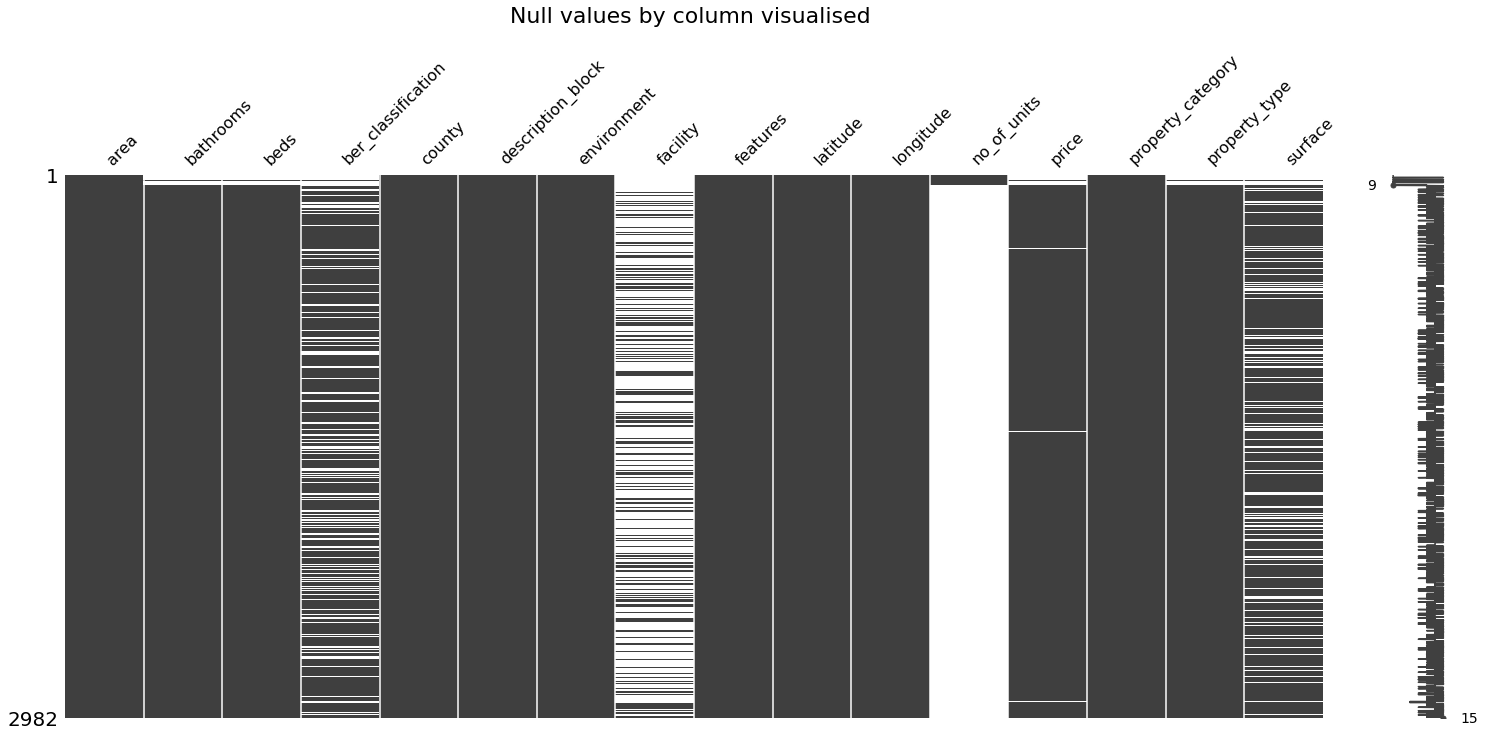

In [112]:
## visualising missing data by column
msno.matrix(dftrain)
plt.title('Null values by column visualised \n', fontsize=22)

% of completeness in each column

In [113]:
## checking the % of complete records for each column
print('% of complete completeness for each colum')
for col in dftrain.columns:
    precentage_complete = round(1-dftrain[col].isnull().sum()/len(dftrain[col]), 3)*100
    print(col, ': ', precentage_complete, '%')

% of complete completeness for each colum
area :  100.0 %
bathrooms :  98.3 %
beds :  98.3 %
ber_classification :  77.3 %
county :  100.0 %
description_block :  100.0 %
environment :  100.0 %
facility :  32.4 %
features :  100.0 %
latitude :  100.0 %
longitude :  100.0 %
no_of_units :  2.0 %
price :  97.0 %
property_category :  100.0 %
property_type :  98.3 %
surface :  81.5 %


Decent completeness overall, areas to investigate: surface, ber_classification, facility, and price

In [114]:
## number of complete rows
print('Number of rows with missing data in any cell: ',dftrain.isnull().any(axis=1).sum())

## rows with complete data
print('Percentage of complete rows: ', round(1-dftrain.isnull().any(axis=1).sum()/len(dftrain), 3)*100, '%')

Number of rows with missing data in any cell:  2982
Percentage of complete rows:  0.0 %


checking out the missingness patterns to decide any imputation methods (1 = present, -1 = missing)

Text(0.5, 1.0, 'Null values matrix')

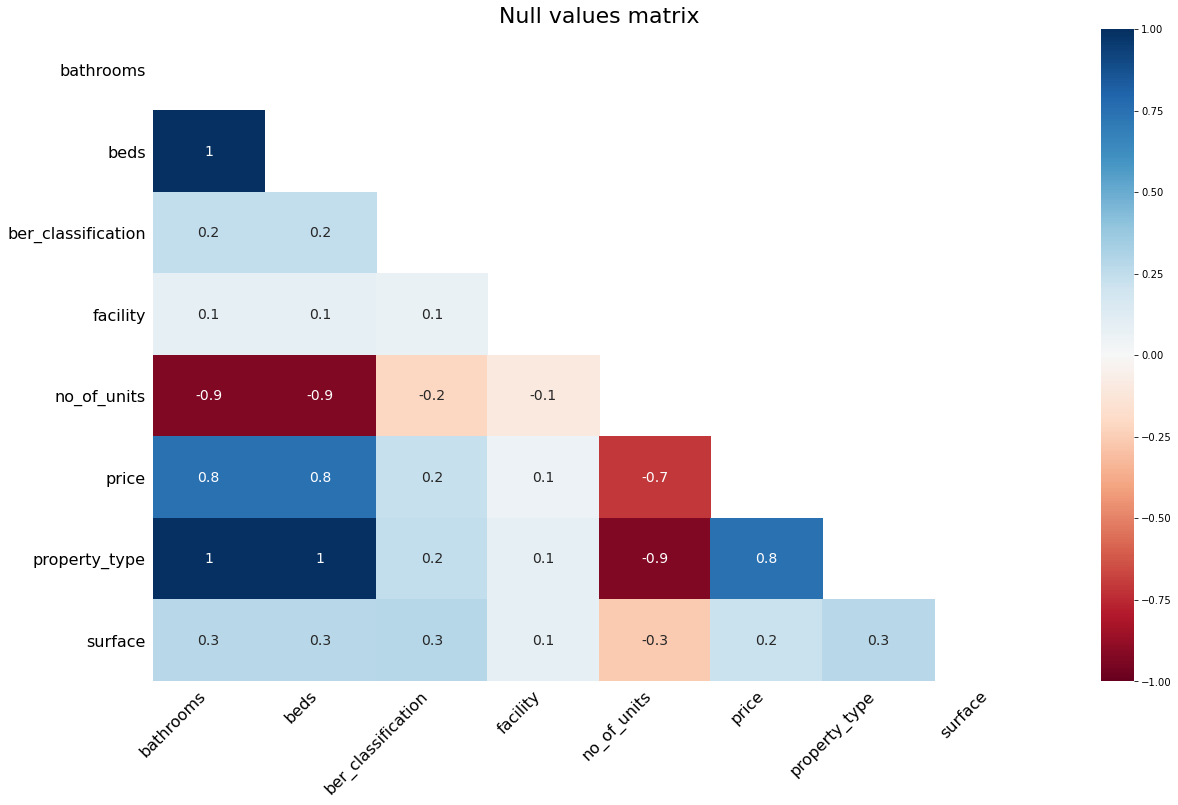

In [115]:
## missingness patterns
msno.heatmap(dftrain)
plt.title('Null values matrix', fontsize=22)

can see that missingness is highly correlated with no_of_units variable

solution could be to remove these properties as they are only a small subset of the data


In [116]:
dftrain = dftrain[dftrain['property_category']!='new_development_parent']
dftrain = dftrain.drop(['property_category', 'no_of_units'], axis=1)


facility variable is converted to a dummy matrix style variable set, negates missing values really, but we could try impute some of the facility values

### Uniqueness: The extent to which there is a lack of duplicates in the data

Measure: number of duplicated rows. As houses can be sold more than once this may become an area of concern in the future, adding a sale ID is one way to counter any duplication issues

In [117]:
## checking for duplicate rows
duplicates = dftrain[dftrain.duplicated()]
print('Number of duplicated rows:',len(duplicates))
## no duplicates 

Number of duplicated rows: 0


In [118]:
## checking the number of unique values for each column
print('Unique values in each column')
for col in dftrain.columns:
    print(col, ':',len(dftrain[col].unique()))

Unique values in each column
area : 156
bathrooms : 13
beds : 15
ber_classification : 17
county : 1
description_block : 2919
environment : 1
facility : 35
features : 1882
latitude : 2820
longitude : 2830
price : 355
property_type : 10
surface : 908


In [119]:
## dropping variables with only 1 unique value (county, environment) and unstructured data (description_block, features)
dftrain =dftrain.drop(['county', 'environment', 'description_block', 'features'], axis = 1)

### Validity: Data that is in the correct format and syntax

In [ ]:
#Checking for wrong entries like symbols -,?,#,*,etc.
for col in dftrain.columns:
    print('{} : {}'.format(col,dftrain[col].unique()))

In [121]:
## removing the incorrect label for BER exempt, and dropping unnecessary columns
dftrain['ber_classification'] = dftrain['ber_classification'].str.replace('SINo666of2006exempt', 'BER Exempt')

Formatting the facility variable to allow for a valid dummy matrix

In [122]:
facility_dummy = f.split_facility(dftrain)

In [123]:
## merging the facility dummy matrix with the dftrain df and dropping dropping facility variable
dftrain = pd.merge(dftrain, facility_dummy, on='ad_id')
dftrain = dftrain.drop('facility', axis = 1)

### Consistency: Ensuring that data is consistent, especially important when variables are interconnected (Ignored, no interconnected variables as outlined in example below)

e.g. if a property has a total number of rooms, then a breakdown of the number of each type of room, the sum of the breakdown should equal the total

### Accuracy: The extent to which the data captured accurately reflects the real world, this can be tough to measure (Ignored, for now)

# Exploratory Data Analysis

In [62]:
dftrain.shape

(2923, 15)

## Outlier Detection and Removal

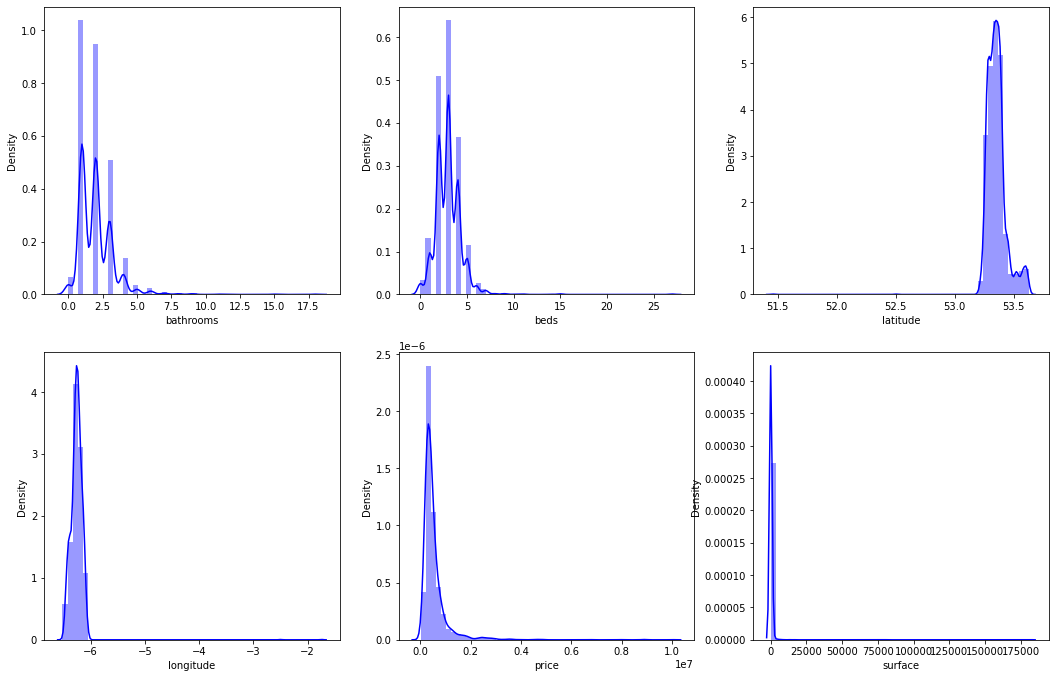

In [124]:
## check the distributions of all variables
dfnum = dftrain.select_dtypes(include='float64')
plt.figure(figsize=(18,18))
for i, column in enumerate(dfnum.columns, 1):
    plt.subplot(3,3,i)
    sns.distplot(dfnum[column], color='b', hist_kws={'alpha': 0.4})

We can see some positively skewed variables in the distribution plots above, to remove outliers in this we will use the interquartile range

In [125]:
Q1, Q3 = dfnum.quantile(0.25), dfnum.quantile(0.75)
IQR = Q3 - Q1
#print(dftrain > (Q1 - 1.5 * IQR)) |(dftrain < (Q3 + 1.5 * IQR))
dfoutliers = dftrain[((dfnum < (Q1 - 1.5 * IQR)) |(dfnum > (Q3 + 1.5 * IQR))).any(axis=1)]
dftrimmed = dftrain[~((dfnum < (Q1 - 1.5 * IQR)) |(dfnum > (Q3 + 1.5 * IQR))).any(axis=1)]

In [126]:
print('Number of outliers:',len(dfoutliers))
print('Number remaining after removing outliers:', len(dftrimmed))

Number of outliers: 465
Number remaining after removing outliers: 2458


In [127]:
## number of outliers for each variable
print('Number of Outliers in each variable')
for column in dfnum:
    print(column, len(dftrain[((dftrain[column] < (Q1[column] - 1.5 * IQR[column])) |(dftrain[column] > (Q3[column] + 1.5 * IQR[column])))]))
print('Total Number of Outliers:', len(dfoutliers))

Number of Outliers in each variable
bathrooms 25
beds 17
latitude 168
longitude 5
price 221
surface 203
Total Number of Outliers: 465


In [102]:
dftrain = dftrimmed

### Price Distribution Comparison (Real vs. Log)


 Price Distribution 
 count       2439.000000
mean      414580.789258
std       185311.120419
min        19995.000000
25%       275000.000000
50%       370000.000000
75%       499950.000000
max      1000000.000000
Name: price, dtype: object

 Log Price Distribution 
 count    2439.000000
mean       12.842714
std         0.428744
min         9.903238
25%        12.524526
50%        12.821258
75%        13.122263
max        13.815511
Name: log_price, dtype: object


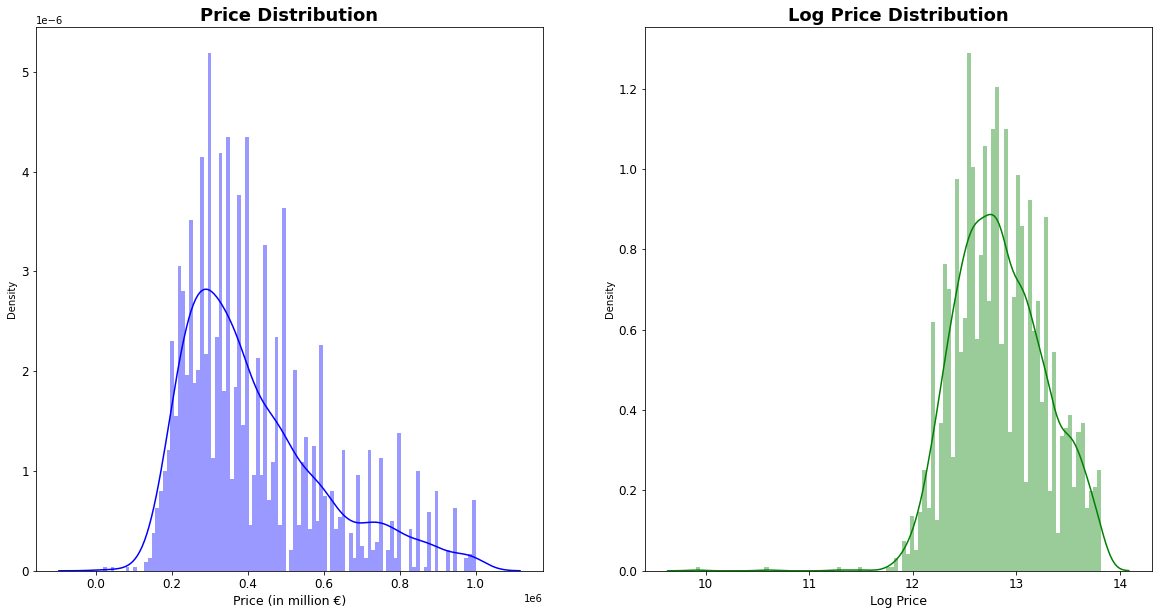

In [104]:
## Looking at the distribution of the price variable
print('\n','Price Distribution', '\n',dftrain['price'].describe().apply(lambda x: format(x, 'f')))

## log transorming price
dftrain['log_price'] = dftrain.price.apply(lambda x: math.log(x))

print('\n','Log Price Distribution', '\n',dftrain['log_price'].describe().apply(lambda x: format(x, 'f')))

## Creating plots
fig, axes = plt.subplots(1,2, figsize = (20,10), sharey=False)
sns.distplot(dftrain['price'], ax = axes[0], color='b', bins=100, hist_kws={'alpha': 0.4});
axes[0].set_title('Price Distribution', weight = 'bold').set_fontsize(18)
## formatting x axis 1
axes[0].ticklabel_format(style='sci', axis='x', scilimits=(6,6))
axes[0].tick_params(axis='x', labelsize=12.0)
axes[0].set_xlabel('Price (in million €)', fontsize = 12.5)
## formatting y axis 1
#axes[0].ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
axes[0].tick_params(axis='y', labelsize=12.0)


sns.distplot(dftrain['log_price'], ax = axes[1], color='g', bins=100, hist_kws={'alpha': 0.4});
axes[1].set_title('Log Price Distribution', weight = 'bold').set_fontsize(18)
## formatting x axis 2
axes[1].tick_params(axis='x', labelsize=12.0)
axes[1].set_xlabel('Log Price', fontsize = 12.5)
## formatting y axis 1
#axes[0].ticklabel_format(style='sci', axis='y', scilimits=(-6,-6))
axes[1].tick_params(axis='y', labelsize=12.0)
## log_price cuts down on the variance, may be easier to predict log price and take exponent of this to get real prediction.

## Relationship between variables

In [ ]:
## extracting numeric values to check their correlation
dfnum.columns
corrMatrix = dfnum.corr()
sns.set(rc = {'figure.figsize':(15,12)})
corrplot = sns.heatmap(corrMatrix, annot=True)
corrplot.set_title('Correlation Matrix for Numeric Variables', weight = 'bold').set_fontsize(18)

In [ ]:
## strength of association for all variables
## Uses Pearson's R for continuous-continuous
## Uses Correlation Ratio for categorical-continuous
## Uses Cramer's V or Theil's U for categorical-categorical
nominal.associations(dftrain, mark_columns=True, title='Strength of Association for all Variables');

## Extra Insights

In [ ]:
## heatmap to see where houses are located
for_map = Map(location=[53.3498, -6.2603], zoom_start=10)

hm_wide = HeatMap(
    list(zip(dftrain['latitude'], dftrain['longitude'])),
    min_opacity=0.2,
    radius=17, 
    blur=15, 
    max_zoom=1,
)

title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format('Location Density Heat Map') 

for_map.get_root().html.add_child(folium.Element(title_html))

for_map.add_child(hm_wide)

for_map

In [ ]:
## for mapping price we drop rows that have missing price (90 rows)
dfpricemap = dftrain[dftrain['price'].notnull()]

for_map2 = Map(location=[53.3498, -6.2603], zoom_start=10)

hm_wide2 = HeatMap(
    list(zip(dfpricemap['latitude'], dfpricemap['longitude'],dfpricemap['price'])),
    min_opacity=0.2,
    radius=17, 
    blur=15, 
    max_zoom=1,
)

title_html = '''
             <h3 align="center" style="font-size:16px"><b>{}</b></h3>
             '''.format('Price Heat Map') 

for_map2.add_child(hm_wide2)

for_map2.get_root().html.add_child(folium.Element(title_html))

for_map2

for_map2.save('map2.html')

In [ ]:
## property type breakdown
fig, axes = plt.subplots(1, figsize=(20,10), sharey=False)
sns.countplot(data=dftrain, x='property_type', color='b', order=dftrain['property_type'].value_counts().index)
axes.set_title('Count by Property Type', weight='bold', fontsize=18.5)

In [ ]:
## BER Breakdown
fig, axes = plt.subplots(1, figsize=(20,10), sharey=False)
sns.countplot(data=dftrain, x='ber_classification', color='b', order=dftrain['ber_classification'].value_counts().index)
axes.set_title('Count by BER Classification', weight='bold', fontsize=18.5)

In [ ]:
print('Property Type Breakdowns\n',dftrain['property_type'].value_counts(), '\n')
print('BER Classification Breakdowns\n',dftrain['ber_classification'].value_counts())

In [105]:
dftrain.to_csv('/Users/andrewtobin/College/final_year/FYP/House_pricing_dataset-master/dataset_csv/cleaned_data.csv')

## Same EDA and Data Cleaning but for the Test Dataset

In [ ]:
print("Training Data Info:")
dftest.info() ## column names, count of non-null values, variable types

print("\n Descriptive Statistics for Numeric Data")
dftest.describe() ## descriptive statistics for our numeric data

In [ ]:
## checking for rows with NANs
print('Missing Values')
dftest.isnull().sum(axis = 0)

In [ ]:
## checking the % of complete records for each column
print('% of complete completeness for each colum')
for col in dftest.columns:
    precentage_complete = round(1-dftest[col].isnull().sum()/len(dftrain[col]), 3)*100
    print(col, ': ', precentage_complete, '%')